In [1]:
import gc
import sys
import mne
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from typing import Tuple, Iterator
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import SlidingEstimator, cross_val_multiscore

In [2]:
BIDS_ROOT = '../data/bids'
FIGS_ROOT = '../figs'
STIM_FREQS = np.array([50, 100, 150, 200, 250])
np.random.seed(0)

In [3]:
print("---------- Load data ----------")
fpath = '/project2/hcn1/imagined_tone/data/bids/derivatives/preprocessing/sub-17/sub-17_task-imagine_run-1_desc-clean_epo.fif.gz'
epochs = mne.read_epochs(fpath)

---------- Load data ----------
Reading /project2/hcn1/imagined_tone/data/bids/derivatives/preprocessing/sub-17/sub-17_task-imagine_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
573 matching events found
No baseline correction applied
0 projection items activated


In [11]:
print("---------- Separate into heard and imagined epochs objects ----------")
epochs_heard = epochs['11', '12']
events_heard = epochs_heard.events
epochs_imagined = epochs['21', '22']
events_imagined = epochs_imagined.events

---------- Separate into heard and imagined epochs objects ----------


In [12]:
# Check event id tags and create label dict for decoder
print("---------- Create event label dicts ----------")
print(epochs_heard.event_id)
label_dict_heard = {10001 : 0, 10002 : 1}
print(epochs_imagined.event_id)
label_dict_imagined = {10003 : 0, 10004 : 1}

---------- Create event label dicts ----------
{'11': 10001, '12': 10002}
{'21': 10003, '22': 10004}


In [9]:
print("---------- Compute power ----------")
n_cycles = STIM_FREQS / 7 # different number of cycle per frequency
                           # higher constant, fewer windows, maybe?
    
# For epochs heard
power_heard = tfr_morlet(epochs_heard,
                   freqs = STIM_FREQS,
                   n_cycles = n_cycles,
                   use_fft = True,
                   return_itc = False,
                   decim = 3,
                   n_jobs = 1,
                   average = False)
power_heard = np.log10(power_heard)

# Get some information
n_epochs = np.shape(power_heard)[0]
n_channels = np.shape(power_heard)[1]
n_freqs = np.shape(power_heard)[2]
n_windows = np.shape(power_heard)[3]
print("n_windows: " + str(n_windows))

# Reshape for classifier
X_heard = power_heard.reshape((n_epochs, n_freqs * n_channels, n_windows)) # Set order to preserve epoch order
print(np.shape(X_heard))

# Repeat for epochs_imagined
power_imagined = tfr_morlet(epochs_imagined,
                   freqs = STIM_FREQS,
                   n_cycles = n_cycles,
                   use_fft = True,
                   return_itc = False,
                   decim = 3,
                   n_jobs = 1,
                   average = False)
power_imagined = np.log10(power_imagined)

# Get some information
n_epochs = np.shape(power_imagined)[0]
n_channels = np.shape(power_imagined)[1]
n_freqs = np.shape(power_imagined)[2]
n_windows = np.shape(power_imagined)[3]
print("n_windows: " + str(n_windows))

# Reshape for classifier
X_imagined = power_imagined.reshape((n_epochs, n_freqs * n_channels, n_windows)) # Set order to preserve epoch order
print(np.shape(X_imagined))

---------- Compute power ----------
Not setting metadata
n_windows: 1667
(456, 310, 1667)
Not setting metadata
n_windows: 1667
(117, 310, 1667)


In [17]:
print("---------- Create target array ----------")
labels_heard = pd.Series(events_heard[:, 2])
y_heard = labels_heard.replace(label_dict_heard)
le = preprocessing.LabelEncoder()
y_heard = le.fit_transform(y_heard)
print(f'y_heard: {y_heard}')

labels_imagined = pd.Series(events_imagined[:, 2])
y_imagined = labels_imagined.replace(label_dict_imagined)
le = preprocessing.LabelEncoder()
y_imagined = le.fit_transform(y_imagined)
print(f'y_heard: {y_imagined}')

---------- Create target array ----------
y_heard: [1 1 1 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1
 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 0 0 0 0 1 1 1 1]
y_heard: [1 0 1 0 1 0 0

In [18]:
print("---------- Decode ----------")
n_stimuli = 2
metric = 'accuracy'

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver = 'liblinear')
)

print("Creating sliding estimators")
time_decod = SlidingEstimator(clf)

print("Fit estimators")
estimator = time_decod.fit(X_heard, y_heard)

---------- Decode ----------
Creating sliding estimators
Fit estimators


  0%|          | Fitting SlidingEstimator : 0/1667 [00:00<?,       ?it/s]

In [21]:
print("---------- apply decoder ----------")
scores = estimator.score(X_imagined, y_imagined)

---------- apply decoder ----------


In [22]:
np.shape(scores)

(1667,)

In [34]:
windows = list(range(len(scores)))
msec_per_window = 1000/1667
x = [window*msec_per_window for window in windows]

999.4001199760047

In [ ]:
print("---------- Save decoder scores ----------")
print('Saving scores to: ' + scores_fpath)
np.save(scores_fpath, scores)

---------- Plot ----------


NameError: name 'sub' is not defined

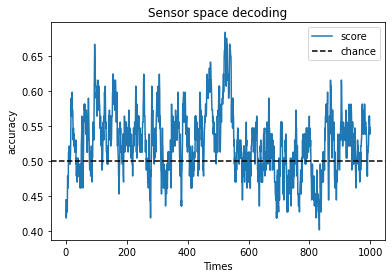

In [35]:
# Plot
print("---------- Plot ----------")
fig, ax = plt.subplots()
ax.plot(x, scores, label = 'score')
ax.axhline(1/n_stimuli, color = 'k', linestyle = '--', label = 'chance')
ax.set_xlabel('Times')
ax.set_ylabel(metric)  # Area Under the Curve
ax.legend()
ax.set_title('Sensor space decoding')

# Save plot
fig_fpath = FIGS_ROOT + '/subj-' + sub + '_' + 'task-pitch_' + 'run-' + run + '_log_reg_no_crop' + '.png'
print('Saving figure to: ' + fig_fpath)
plt.savefig(fig_fpath)